In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import io
import scipy.io as sio
%matplotlib inline 
import pylab
import csv
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import nibabel as nb
from scipy import io
#from nifti import NiftiImage
import nibabel as nb
from scipy.interpolate import interp1d
from scipy import ndimage

# Open data

In [2]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/918/918ss1regc1000dFF20spsfkf118Smith0_4_60TS.mat


In [3]:
Ua=sio.loadmat(filename)
DT=Ua['TSo']
DT.shape

(11158, 118)

In [4]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/918/918ss1regc1000dFF20spsfkf118Smith0_4_60IC.nii


In [5]:
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

(85, 46, 10, 118)

In [6]:
S=data.shape
S

(85, 46, 10, 118)

Z-score

In [7]:
Demean=np.zeros(S)
Dmaps=np.zeros(S)
Dvar=np.zeros(S)
Var=np.zeros(S[3])
D2=np.zeros([S[0],S[1],5,S[3]])
Tvar=np.zeros(S[3])

In [8]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(np.mean(data[:,:,:,i],0),0),0)

In [9]:
for i in range(S[3]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.sqrt(np.var(Dsq))
    Dvar=Demean[:,:,:,i]/Var[i]
    Dmaps[:,:,:,i]=Dvar-2.5
    Tvar[i]=np.var(DT[i,:])
Dmaps[Dmaps<0]=0

# Open Masks

In [10]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenameM = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenameM)
img1 = nb.load(filenameM)
Masks = img1.get_data()
Sm=Masks.shape
Masks=np.array(Masks)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/918/918Registration/JFRCTransformedLargefullpsftrimmed.nii


In [11]:
filenameM='/home/sophie/LargeRegionList'
with open(filenameM) as f:
    content = f.readlines()
Names=[Line.replace('\n','').split(' ') for Line in content]
RegionName=[Names[i][1] for i in range(12)]
Num=[int(Names[i][0]) for i in range(12)]

In [12]:
RegNum=dict(zip(RegionName,Num))

In [13]:
RegNum['OL']

1

# Average in masks to sort components by brain region

In [14]:
Dmaps.shape

(85, 46, 10, 118)

In [15]:
M=np.zeros((S[3],13))
Mapmean=np.zeros(S[3])
MMasks=np.zeros(13)

In [16]:
for i in range(S[3]):
    Mapmean[i]=np.mean(np.mean(np.mean(Dmaps[:,:,:,i])))
    for j in range(12):
        MMasks[j]=np.mean(np.mean(np.mean(Masks[:,:,:,j])))
        if MMasks[j]:
            M[i,j]=np.mean(np.mean(np.mean(Masks[:,:,:,j]*Dmaps[:,:,:,i])))/(MMasks[j]*Mapmean[i])

In [17]:
CompMainName=S[3]*['']
CompNameAdd=np.zeros((S[3],12))
for i in range(S[3]):
    Max=np.max(M[i,:])
    I=np.argmax(M[i,:])+1
    for j in range(12):
        J=[l for l in range(12) if Num[l]==(j+1)]
        if M[i,j]>0.2*Max:
            CompNameAdd[i,J]=1
    J=[l for l in range(12) if Num[l]==I]
    if J!= []:
        CompMainName[i]=Names[np.array(J)][0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [18]:
J

[7]

OL


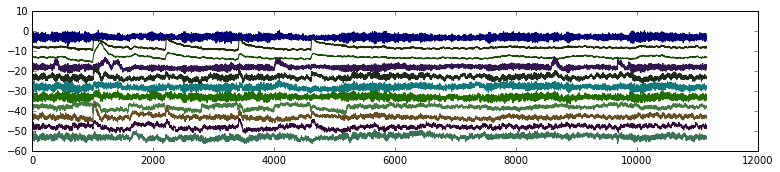

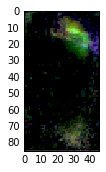

VLNP


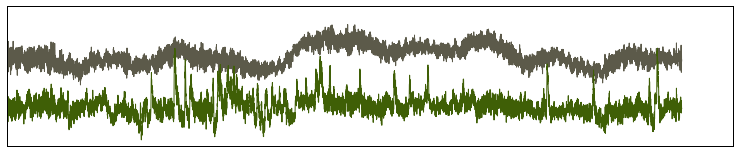

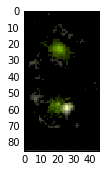

VMNP


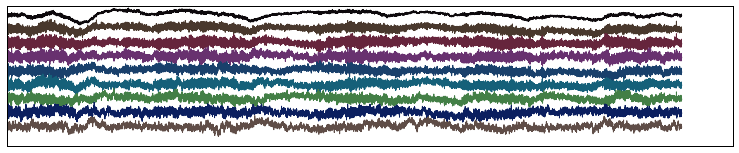

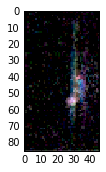

AL


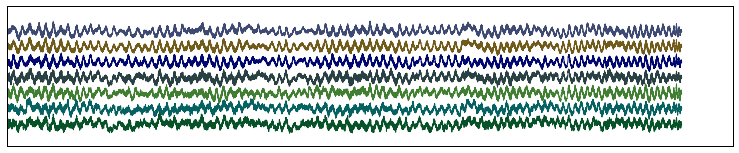

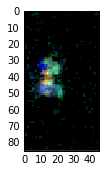

MB


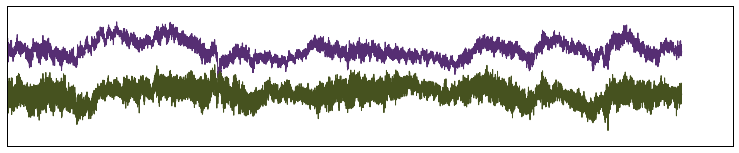

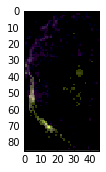

LH


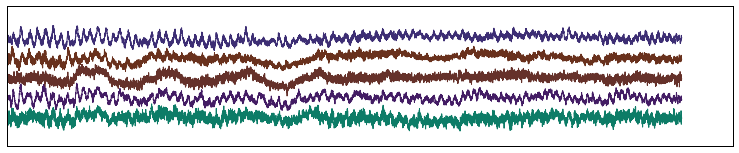

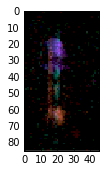

SNP


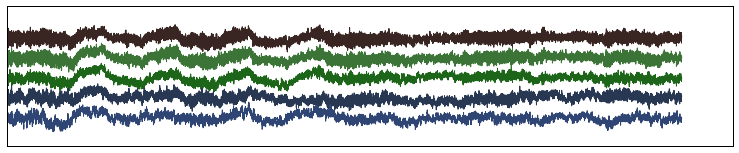

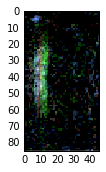

CX


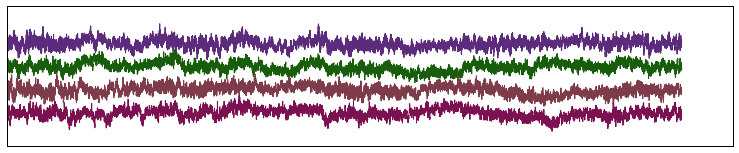

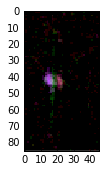

INP


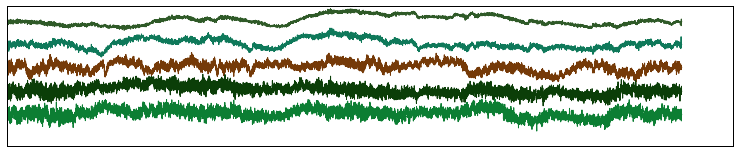

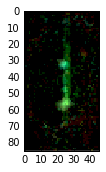

PENP


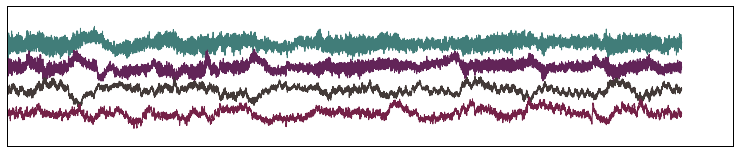

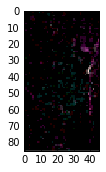

GNG


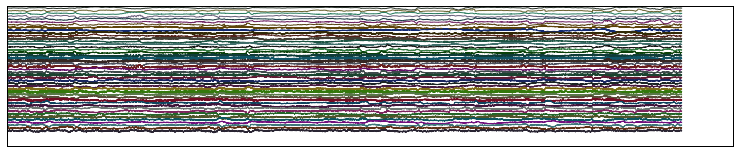

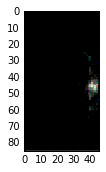

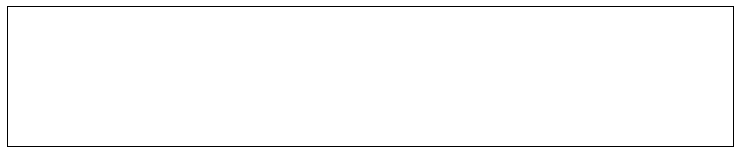

In [19]:
pylab.rcParams['figure.figsize'] = (13, 2.5)

h=5
tot=0
GoodICAnat=np.zeros(S[3])

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*C[k]/np.max(C)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        


##### Looked at the components maps and time series and remove all the components which are localized on the edge of the brain and with activity unlike GCaMP6 transients.


In [20]:
BadICs=[73,95,99,116,101,79,77,92,100,76,27,75,43,102,60,67,0,1,2,4,7,8,10,12,16,17,20,30,31,32,33,35,41,42,45,46,50,51,56,58,59,68,78,81,83,87,96,103,37,84,71,15,21,91,64,80]

In [21]:
for idx in BadICs:
    GoodICAnat[idx] = 0.0

5
11
14
28
54
66
74
85
90
OL


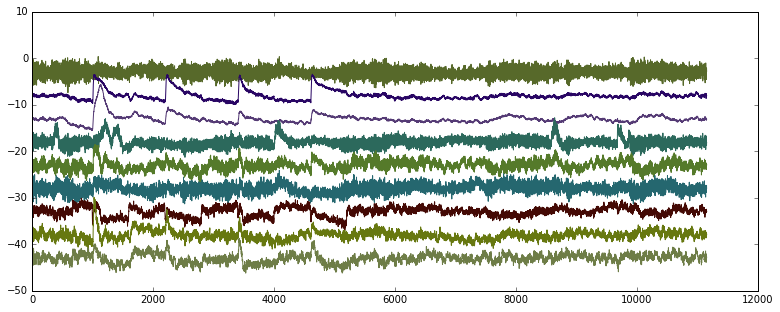

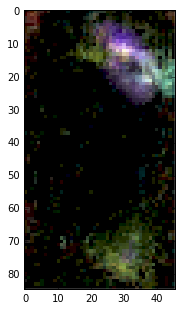

9
97
VLNP


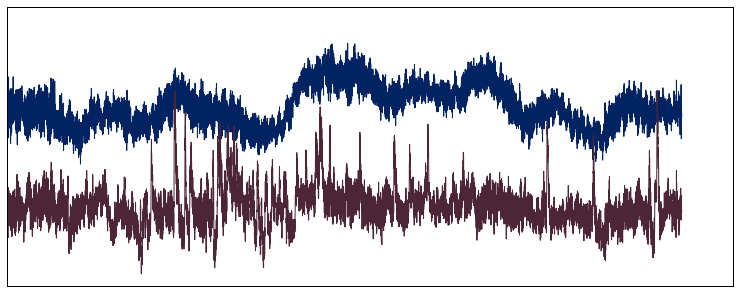

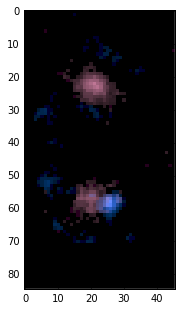

6
23
57
65
98
VMNP


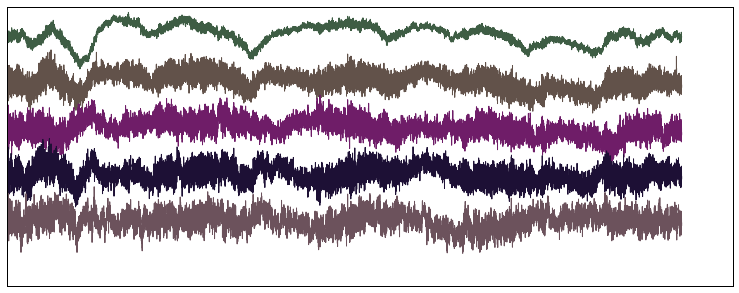

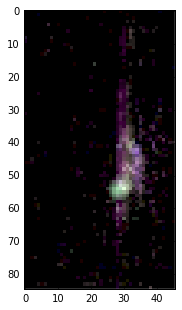

18
19
24
53
55
69
70
AL


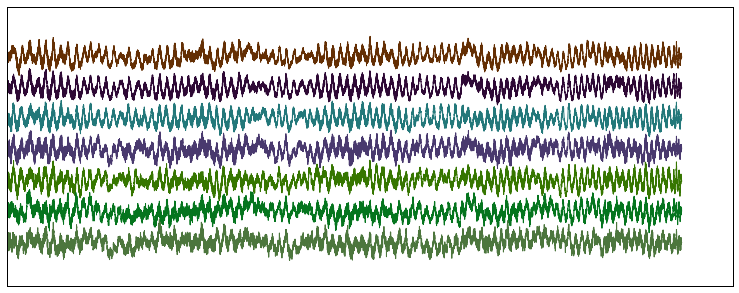

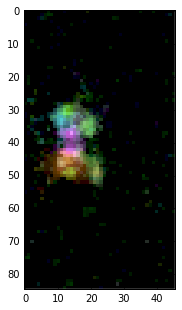

49
52
72
88
LH


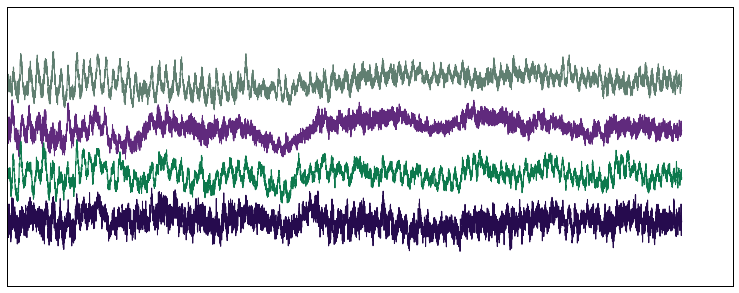

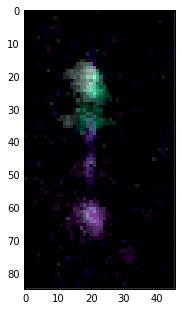

25
40
48
63
SNP


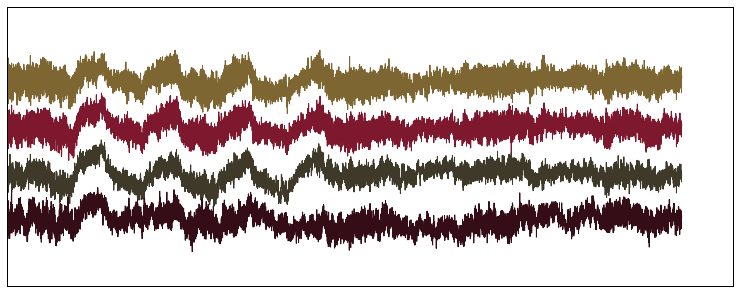

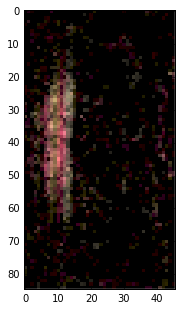

82
105
109
CX


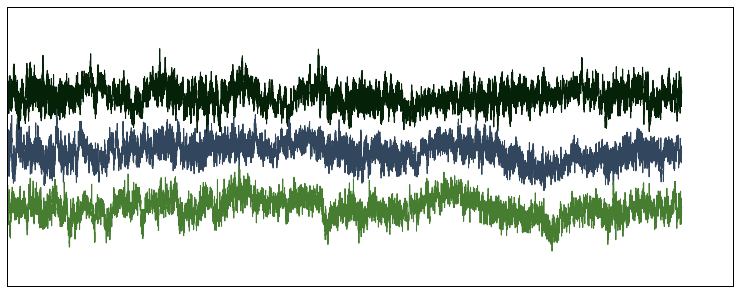

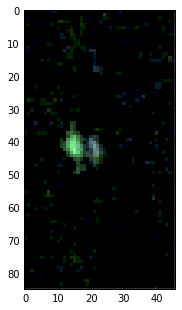

3
22
INP


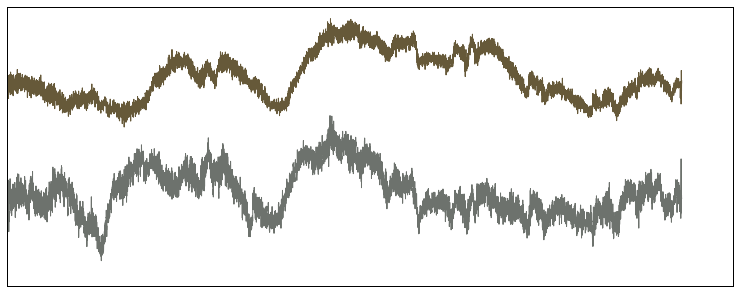

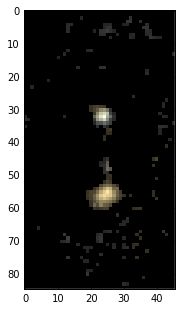

38
44
93
PENP


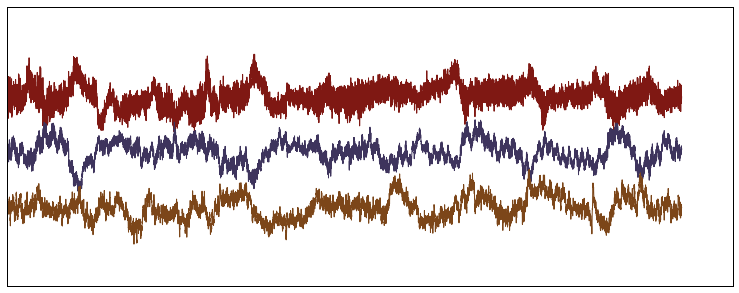

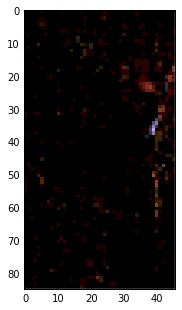

13
26
29
39
47
62
94
GNG


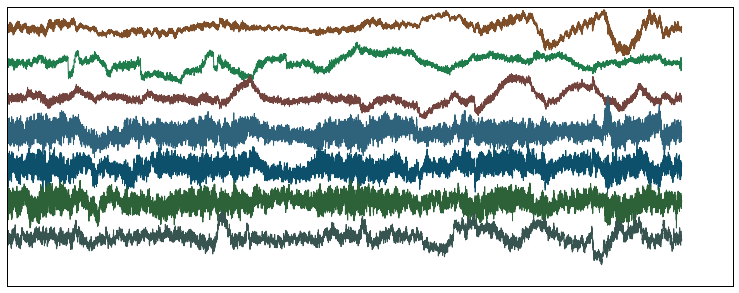

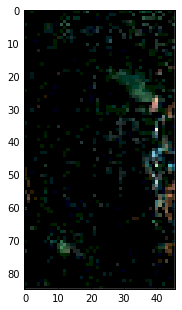

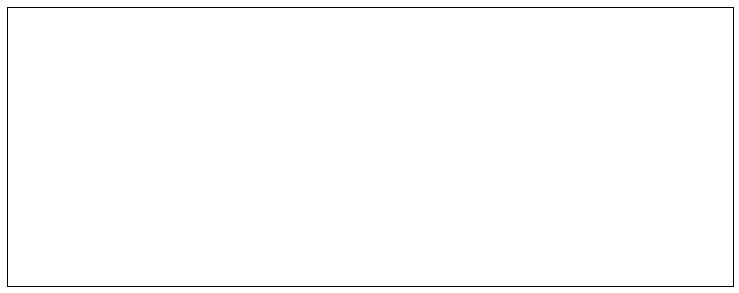

In [22]:
pylab.rcParams['figure.figsize'] = (13, 5)

h=5
tot=0
NumberInLargeRegion=np.zeros(13)

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200 and GoodICAnat[i]==1:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*(C[k]+0.2)/np.max(C+0.2)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            print(i)
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
                
    NumberInLargeRegion[l]=n
        

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/918/918X.mat


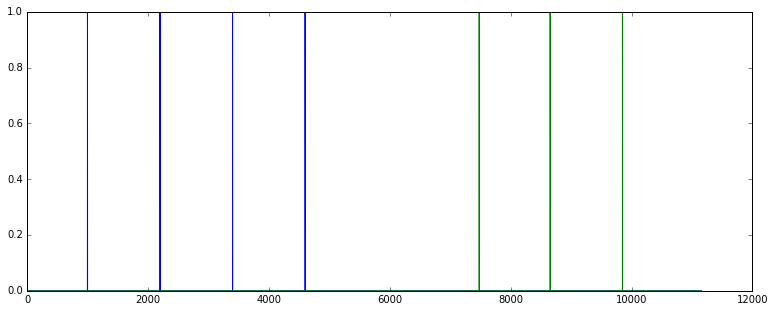

In [23]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)
X=Ua['X']

plt.plot(X.T)

Sx=X.shape

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/918/918Registration/AVG_918ss1regc1000.nii


/usr/local/lib/python2.7/dist-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


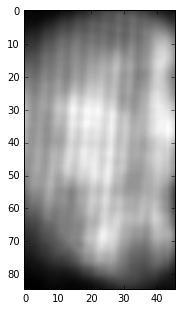

In [24]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenamet = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenamet)
nimt=nb.load(filenamet)
Dtemp=np.squeeze(nimt.get_data())
Dtemp.shape

if S[2]>5:
    Nstack=5
    Int100=[(i+1)*100/Nstack for i in range(Nstack)]
    Percs=np.percentile(range(S[2]),Int100)
    Indices=np.split(range(S[2]),Percs)
    D1=np.zeros([S[0],S[1],Nstack])
    Dmean=np.squeeze(data[:,:,range(Nstack),2])
    for i in range(Nstack):
        Vmean=np.mean(Dtemp[:,:,Indices[i]],2)
        Dmean[:,:,i]=Vmean
else:
    Nstack=S[2]
    D1=np.zeros([S[0],S[1],S[2]])
    Dmean=data[:,:,range(S[2])]  
    Dmean=np.squeeze(Dtemp[:,:,:])

for j in range(S[3]):

    a=''
    if S[2]>5:
        for i in range(Nstack):
            V=Dmaps[:,:,Indices[i],j]
            D1[:,:,i]=np.max(V,2)
        D2[:,:,:,j]=D1
        D1[D1==0]=np.nan

plt.imshow(Dmean[:,:,1],cmap=plt.cm.gray)

In [25]:
AvLightIC=np.zeros(DT.shape[1])        
for j in range(S[3]):
    k=0
    for i in range(Sx[1]):
        if X[0,i]==1:
            AvLightIC[j]=AvLightIC[j]+(np.mean(DT[i:i+200,j])-np.mean(DT[i-200:i,j]))/(2*np.std(DT[i-200:i,j]))
            k=k+1
    AvLightIC[j]=AvLightIC[j]/k

In [26]:
AvOdorIC=np.zeros(DT.shape[1])        
for j in range(S[3]):
    k=0
    for i in range(Sx[1]):
        if X[1,i]==1:
            AvOdorIC[j]=AvOdorIC[j]+(np.mean(DT[i:i+200,j])-np.mean(DT[i-200:i,j]))/(2*np.std(DT[i-200:i,j]))
            k=k+1
    AvOdorIC[j]=AvOdorIC[j]/k

In [27]:
my_cmap=plt.cm.jet
my_cmap.set_bad(alpha=0)
pylab.rcParams['figure.figsize'] = (15, 2.5)

In [28]:
if S[2]>5:
    Final_map=np.zeros([S[0],S[1],5,3])
    Fmaps=np.zeros([S[0],S[1],5,3])
else:
    Final_map=np.zeros([S[0],S[1],3]) 
    Fmaps=np.zeros([S[0],S[1],3])    
C=np.zeros([S[3],3])
C1=np.zeros([6,3])
C1[0][:]=(1,0,0)
C1[1][:]=(0,1,0)
C1[2][:]=(0,0,1)
C1[3][:]=(0.8,0.8,0)
C1[4][:]=(0,1,1)
C1[5][:]=(1,0,1)
S1=DT.shape

In [29]:
C=np.zeros((S[3],3))
i=0
l=0

LightNuminRegion=np.zeros(12)
for j in range(S[3]):  
    if AvLightIC[j]>1:
        #C[j,:]=C1[i%6][:]
        C[j,2]=1
        C[j,1]=1
        #C[j,2]=1
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.5*D2[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        #Betas[0,j]=0
        #print(Indexo[j])
        print(j+1)
        print(CompMainName[j])     
        
        i=i+1
        l=l+1
        LightNuminRegion[int(CompMainName[j])-1]=LightNuminRegion[int(CompMainName[j])-1]+1
        #if l==2:
            #break
    

1
12
2
12
8
12
9
12
12
1
15
1


In [30]:
LightNuminRegion

array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.])

In [31]:
C=np.zeros((S[3],3))
i=0
l=0

OdorNuminRegion=np.zeros(12)
for j in range(S[3]):  
    if AvOdorIC[j]>1:
        #C[j,:]=C1[i%6][:]
        C[j,0]=1
        C[j,1]=0
        #C[j,2]=1
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.5*D2[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        #Betas[0,j]=0
        #print(Indexo[j])
        print(j+1)
        print(CompMainName[j])     
        OdorNuminRegion[int(CompMainName[j])-1]=OdorNuminRegion[int(CompMainName[j])-1]+1        
        i=i+1
        l=l+1

7
3
13
12
35
12
45
11


In [32]:
OdorNuminRegion

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.])

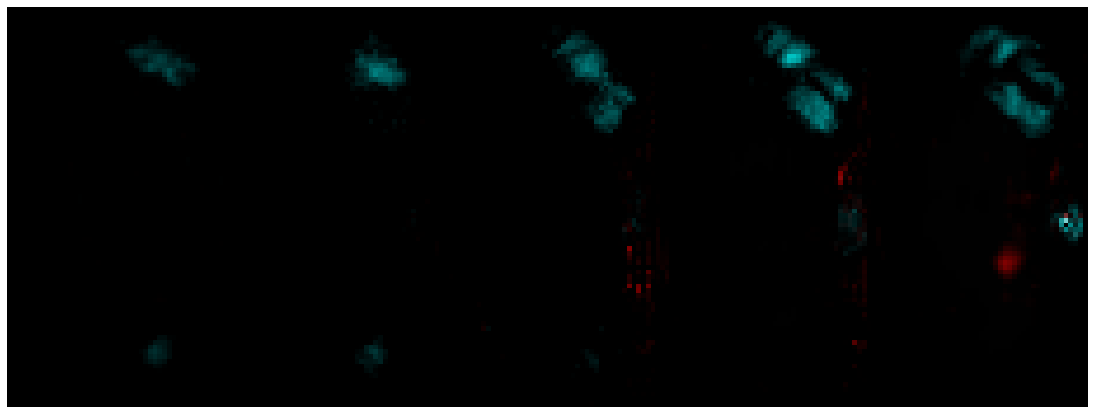

In [33]:
pylab.rcParams['figure.figsize'] = (15, 6)
C2=np.zeros(3)

Df=np.zeros([S[0],S[1],5,3]) 
  
for i in range(3):
    Df[:,:,:,i]=Final_map[:,:,:,i]+Dmean/500
    #Df=Df/(np.max(np.max(np.max(Df),3)))
if S[2]>5:
    N=Nstack
else:
    N=S[2]
for i in range(N):
    #if Good_ICs[j]:
        plt.subplot(1,N,i+1)
        plt.imshow(Df[:,:,i],cmap=plt.cm.gray)
        plt.imshow(Df[:,:,i,:],cmap=my_cmap,interpolation='none')
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
plt.tight_layout(pad=0,w_pad=0,h_pad=0)

In [34]:
np.savetxt('/'.join(filename.split('/')[:-1])+'/NumberInLargeRegionsLight.txt',LightNuminRegion)
np.savetxt('/'.join(filename.split('/')[:-1])+'/NumberInLargeRegionsOdor.txt',OdorNuminRegion)